In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/219-DataMining/Project2/

/content/drive/MyDrive/219-DataMining/Project2


# IMPORTS

In [3]:
!pip install umap-learn[plot]
!pip install hdbscan

     |████████████████████████████████| 86 kB 876 kB/s 
     |████████████████████████████████| 1.1 MB 9.0 MB/s 
     |████████████████████████████████| 15.8 MB 1.9 MB/s 
     |████████████████████████████████| 76 kB 3.8 MB/s 
     |████████████████████████████████| 133 kB 11.8 MB/s 
     |████████████████████████████████| 830 kB 41.4 MB/s 
     |████████████████████████████████| 822 kB 42.4 MB/s 
     |████████████████████████████████| 802 kB 50.1 MB/s 
     |████████████████████████████████| 802 kB 53.5 MB/s 
     |████████████████████████████████| 793 kB 46.5 MB/s 
     |████████████████████████████████| 793 kB 45.5 MB/s 
     |████████████████████████████████| 791 kB 46.9 MB/s 
     |████████████████████████████████| 786 kB 49.9 MB/s 
     |████████████████████████████████| 779 kB 45.5 MB/s 
     |████████████████████████████████| 778 kB 43.4 MB/s 
     |████████████████████████████████| 776 kB 11.7 MB/s 
     |████████████████████████████████| 769 kB 52.4 MB/s 
     |█████████████

     |████████████████████████████████| 6.4 MB 3.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311912 sha256=315be975365952a2c5716da01ed2a4e03945c59729ef141e32c52d28ccfadd1f
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [4]:
import numpy as np
import umap
import itertools
import hdbscan

from plotmat import plot_mat
from matplotlib import pyplot as plt
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE

from scipy.optimize import linear_sum_assignment

# READING AND UNDERSTANDING THE DATASET

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='all', remove = ('headers', 'footers'), shuffle = True)

In [ ]:
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [ ]:
print(newsgroups_train.filenames.shape)

(18846,)


EXTRACTING REQUIRED CLASSES

In [ ]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
X = fetch_20newsgroups(subset='all', categories = categories, remove = ('headers', 'footers'), shuffle = True)
print(X.filenames.shape)

(7882,)


In [ ]:
def create_labels(dataset):
    labels = list()
    print(len(dataset.target))
    for i in range(len(dataset.data)):
        if dataset.target[i] in (0, 1, 2, 3):
            labels.append(0)
        else:
            labels.append(1)
    return labels

In [ ]:
X_labels = create_labels(X)

7882


TF-IDF TRANSFORMER

In [ ]:
tfidf = TfidfVectorizer(min_df=3, stop_words='english')
X_train = tfidf.fit_transform(X.data)
print(X_train.shape)

(7882, 23522)


##K-MEANS CLUSTERING

In [ ]:
# def plot_matrix(contingency_matrix, class_names, cluster_names, pic_fname = None):
#     plt.gcf().clear()
#     contin_matrix = metrics.ConfusionMatrixDisplay(contingency_matrix)
#     contin_matrix.plot(cmap=plt.cm.Purples,)
#     plt.xticks(rotation = 45)
#     plt.title("Contingency Table")
#     plt.ylabel('Cluster Class')
#     plt.xlabel('Actual Class')
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names)
#     plt.yticks(tick_marks, cluster_names)
#     plt.show()

In [5]:
def plot_matrix(contingency_matrix, class_names, cluster_names, pic_fname = 'Contingency Table', size = (15,15)):
    rows, cols = linear_sum_assignment(contingency_matrix, maximize=True)
    plot_mat(contingency_matrix[rows[:, np.newaxis], cols], xticklabels = cols, yticklabels = rows, pic_fname = pic_fname, size = size)

In [6]:
def k_means(training_set, labels, clusters, class_names=['Class 1', 'Class 2'], 
            cluster_names=['Cluster 1', 'Cluster 2'], random_state=0, max_iter=1000, n_init=500, plot_confusion_flag=True):
    
    km = KMeans(init='k-means++', n_clusters=clusters, random_state=random_state, max_iter=max_iter, n_init=n_init)
    km.fit(training_set)
    contingency_matrix = metrics.cluster.contingency_matrix(labels, km.labels_)
    
    if plot_confusion_flag == True:
        print("CONTINGENCY TABLE:")
        plot_matrix(contingency_matrix, class_names, cluster_names)
    
    print("METRICS")
    
    homogeneity = metrics.homogeneity_score(labels, km.labels_)
    print("Homogeneity Score: {}".format(homogeneity))
    completeness = metrics.completeness_score(labels, km.labels_)
    print("Completeness Score: {}".format(completeness))
    v_measure = metrics.v_measure_score(labels, km.labels_)
    print("V-Measure Score: {}".format(v_measure))
    adjusted_rand_index = metrics.adjusted_rand_score(labels, km.labels_)
    print("Adjusted Rand Index: {}".format(adjusted_rand_index))
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(labels, km.labels_)
    print("Adjusted Mutual Information: {}".format(adjusted_mutual_info))
    
    return {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }, km

CONTINGENCY TABLE:


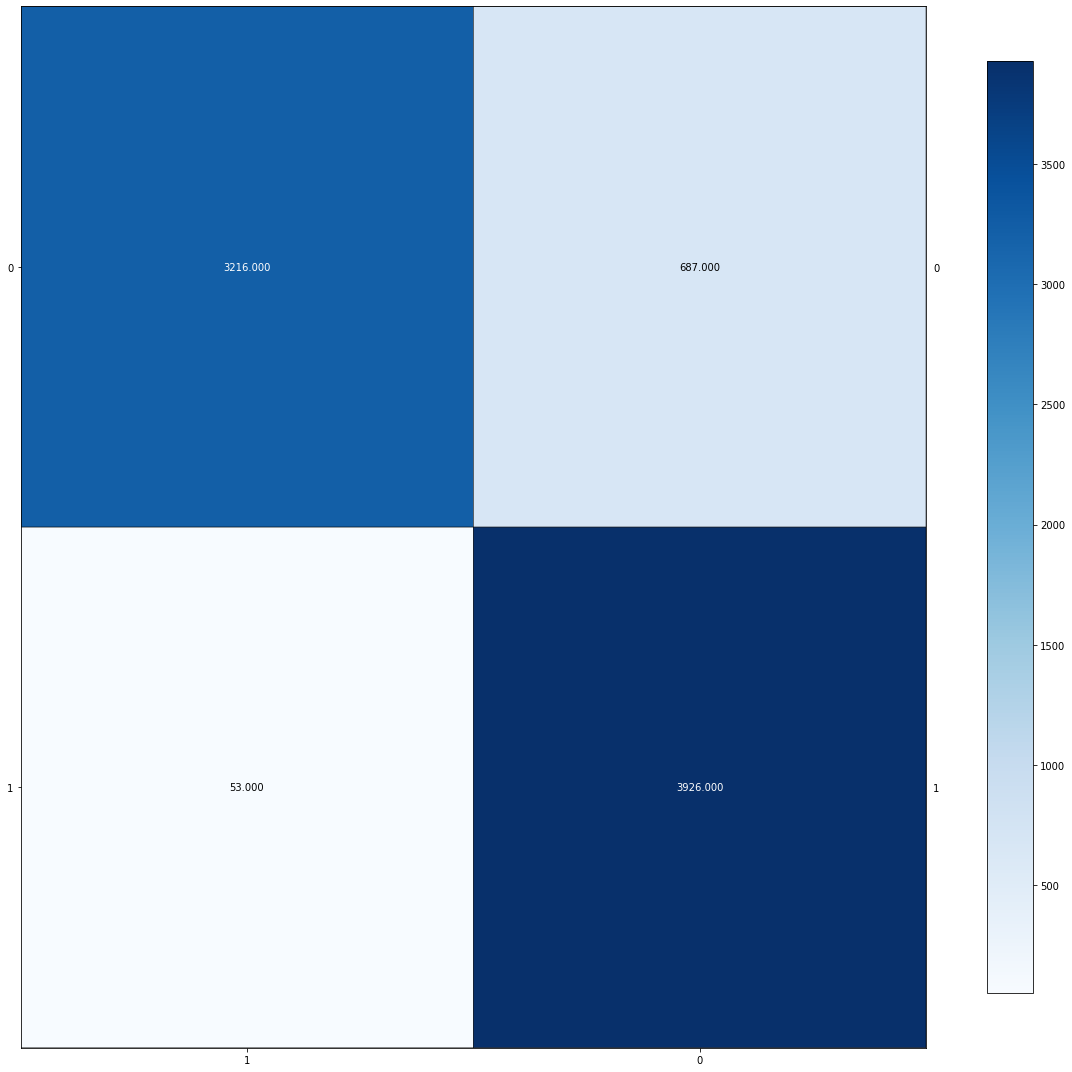

METRICS
Homogeneity Score: 0.5950259664335722
Completeness Score: 0.6077961559190183
V-Measure Score: 0.6013432715437038
Adjusted Rand Index: 0.6596753766116282
Adjusted Mutual Information: 0.6013063866080842


In [ ]:
res, km = k_means(X_train, X_labels, clusters=2, plot_confusion_flag=True)

# DENSE REPRESENTATIONS FOR BETTER K-MEANS CLUSTERING

PLOT OF PERCENTAGE OF VARIANCE

Text(0.5, 0, 'r')

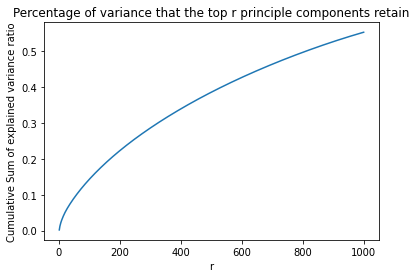

In [ ]:
model = TruncatedSVD(n_components=1000)
output = model.fit(X_train)
r = list(range(1, 1001))
evr = model.explained_variance_ratio_
evr_cumulative = np.cumsum(evr)
plt.plot(r, evr_cumulative)
plt.title("Percentage of variance that the top r principle components retain")
plt.ylabel('Cumulative Sum of explained variance ratio')
plt.xlabel('r')

RESULTS OF DIMENSIONALITY REDUCTION

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_homogeneity = list()
svd_completeness = list()
svd_v_measure = list()
svd_adjusted_rand_index = list()
svd_adjusted_mutual_info = list()


for val in r:
    print("Computing Truncated SVD for r = " + str(val) + "...")
    lsi = TruncatedSVD(n_components=val)
    output = lsi.fit_transform(X_train)
    scores, km = k_means(output, X_labels, clusters=2, plot_confusion_flag=False)
    svd_homogeneity.append(scores['homogeneity'])
    svd_completeness.append(scores['completeness'])
    svd_v_measure.append(scores['v_measure'])
    svd_adjusted_rand_index.append(scores['adjusted_rand_index'])
    svd_adjusted_mutual_info.append(scores['adjusted_mutual_info'])
    print("---" * 20)

Computing Truncated SVD for r = 1...
METRICS
Homogeneity Score: 0.018956544515354657
Completeness Score: 0.019260434831635448
V-Measure Score: 0.01910728144974337
Adjusted Rand Index: 0.025920756456215145
Adjusted Mutual Information: 0.01901676579673226
------------------------------------------------------------
Computing Truncated SVD for r = 2...
METRICS
Homogeneity Score: 0.5302977093494572
Completeness Score: 0.5477484388597662
V-Measure Score: 0.5388818334160995
Adjusted Rand Index: 0.58677960459435
Adjusted Mutual Information: 0.5388389339976963
------------------------------------------------------------
Computing Truncated SVD for r = 3...
METRICS
Homogeneity Score: 0.5372146339804388
Completeness Score: 0.5540561285056713
V-Measure Score: 0.5455054245230577
Adjusted Rand Index: 0.5949729333519391
Adjusted Mutual Information: 0.545463172738877
------------------------------------------------------------
Computing Truncated SVD for r = 5...
METRICS
Homogeneity Score: 0.51733231

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]
nmf_homogeneity = list()
nmf_completeness = list()
nmf_v_measure = list()
nmf_adjusted_rand_index = list()
nmf_adjusted_mutual_info = list()


for val in r:
    print("Computing NMF for r = " + str(val) + "...")
    nmf = NMF(n_components=val, init='random', random_state=42, max_iter=500)
    output = nmf.fit_transform(X_train)
    scores, km = k_means(output, X_labels, clusters=2, plot_confusion_flag=False)
    nmf_homogeneity.append(scores['homogeneity'])
    nmf_completeness.append(scores['completeness'])
    nmf_v_measure.append(scores['v_measure'])
    nmf_adjusted_rand_index.append(scores['adjusted_rand_index'])
    nmf_adjusted_mutual_info.append(scores['adjusted_mutual_info'])
    print("---" * 20)

Computing NMF for r = 1...
METRICS
Homogeneity Score: 0.018956544515354657
Completeness Score: 0.019260434831635448
V-Measure Score: 0.01910728144974337
Adjusted Rand Index: 0.025920756456215145
Adjusted Mutual Information: 0.01901676579673226
------------------------------------------------------------
Computing NMF for r = 2...
METRICS
Homogeneity Score: 0.49465130975968324
Completeness Score: 0.52035408497699
V-Measure Score: 0.5071772642931544
Adjusted Rand Index: 0.5291689826328091
Adjusted Mutual Information: 0.5071310027576791
------------------------------------------------------------
Computing NMF for r = 3...
METRICS
Homogeneity Score: 0.19985564752182014
Completeness Score: 0.2950307721693631
V-Measure Score: 0.23829130751886396
Adjusted Rand Index: 0.11986506221272898
Adjusted Mutual Information: 0.23820814539674384
------------------------------------------------------------
Computing NMF for r = 5...
METRICS
Homogeneity Score: 0.040791321221174695
Completeness Score: 0.1

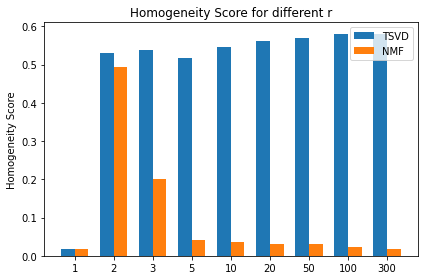

In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_homogeneity, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_homogeneity, width, label='NMF')

ax.set_ylabel('Homogeneity Score')
ax.set_title('Homogeneity Score for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()


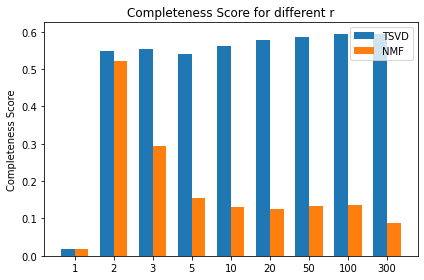

In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_completeness, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_completeness, width, label='NMF')

ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()


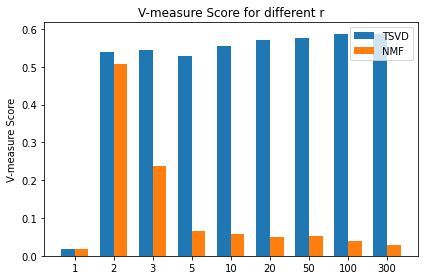

In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_v_measure, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_v_measure, width, label='NMF')

ax.set_ylabel('V-measure Score')
ax.set_title('V-measure Score for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()


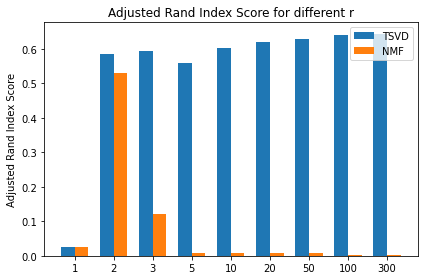

In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_adjusted_rand_index, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_adjusted_rand_index, width, label='NMF')

ax.set_ylabel('Adjusted Rand Index Score')
ax.set_title('Adjusted Rand Index Score for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


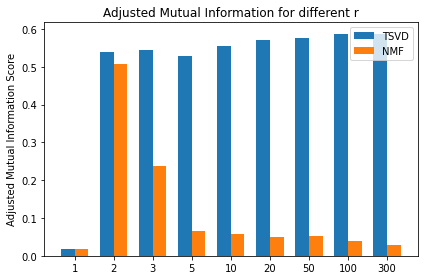

In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_adjusted_mutual_info, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_adjusted_mutual_info, width, label='NMF')

ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


In [ ]:
svd_mean = list()
nmf_mean = list()
for val in range(len(r)):
    svd_sum = svd_homogeneity[val] + svd_completeness[val] + svd_v_measure[val] + svd_adjusted_rand_index[val] + svd_adjusted_mutual_info[val]
    nmf_sum = nmf_homogeneity[val] + nmf_completeness[val] + nmf_v_measure[val] + nmf_adjusted_rand_index[val] + nmf_adjusted_mutual_info[val]
    svd_mean.append(svd_sum / 5)
    nmf_mean.append(nmf_sum / 5)

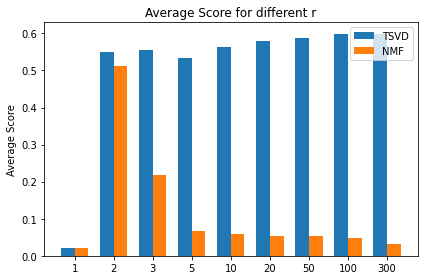

------------------------------------------------------------
[1, 2, 3, 5, 10, 20, 50, 100, 300]
Average Scores for SVD for the above rs
[0.020452356609936172, 0.5485093040434739, 0.5554424586199967, 0.5345233937482977, 0.5641223295062283, 0.5807853100705133, 0.5879547697142263, 0.5973116518244396, 0.5996817505492171]
Average Scores for NMF for the above rs
[0.020452356609936172, 0.5116965288840631, 0.21825018696390402, 0.06655002071442459, 0.057955702319713885, 0.05294746084520878, 0.054666071109732296, 0.04795333373734359, 0.03293940179052143]


In [ ]:
labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']

x = np.arange(len(labels))  
width = 0.35                       

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svd_mean, width, label='TSVD')
rects2 = ax.bar(x + width/2, nmf_mean, width, label='NMF')

ax.set_ylabel('Average Score')
ax.set_title('Average Score for different r')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
print("---" * 20)
print(r)
print("Average Scores for SVD for the above rs")
print(svd_mean)
print("Average Scores for NMF for the above rs")
print(nmf_mean)

## VISUALIZATION

In [7]:
def k_means_viz(k_means, cluster, true_label, title_name = ''):
    plt.gcf().clear()
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.scatter(x=cluster[:,0], y=cluster[:,1], c=k_means.labels_, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20b'), vmin=0, vmax=20, alpha=0.5)    
    ax1.set_title('Clustering Result')

    ax2.scatter(x=cluster[:,0], y=cluster[:,1], c=true_label, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20b'), vmin=0, vmax=20, alpha=0.5)
    ax2.set_title('True Class')
    fig.suptitle('Clustering Visualization for {}'.format(title_name))
    plt.show()

In [8]:
def svd_train(training_data, cat_labels, components, clusters=2, method='SVD'):
  svd = TruncatedSVD(n_components=components)
  svd_dataset = svd.fit_transform(training_data)
  print('Metrics, Contingency Table and the Clustering Results for {} method with components = {}'.format(method, components))
  _, svd_km = k_means(svd_dataset, cat_labels, clusters=clusters, random_state=0, max_iter=1000, n_init=500, plot_confusion_flag=True)
  k_means_viz(svd_km, svd_dataset, cat_labels, method)

Metrics, Contingency Table and the Clustering Results for SVD method with components = 300
CONTINGENCY TABLE:


<Figure size 432x288 with 0 Axes>

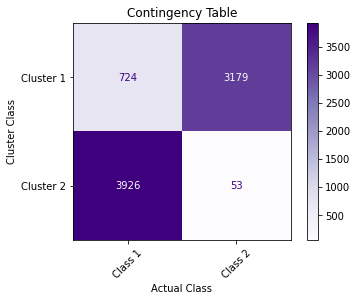

METRICS
Homogeneity Score: 0.5823919544710606
Completeness Score: 0.5963517903683252
V-Measure Score: 0.5892892094070018
Adjusted Rand Index: 0.6445104328741661
Adjusted Mutual Information: 0.5892511630512971


<Figure size 432x288 with 0 Axes>

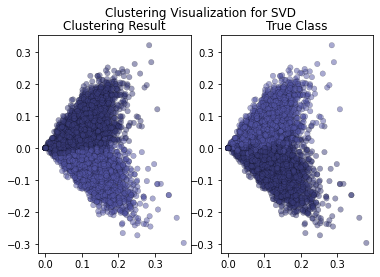

In [ ]:
svd_train(X_train, X_labels, components=300, clusters=2)

In [ ]:
def nmf_train(training_data, cat_labels, components, clusters=2, method='NMF'):
  nmf = NMF(n_components=components)
  nmf_dataset = nmf.fit_transform(training_data)
  print('Metrics, Contingency Table and the Clustering Results for {} method with components = {}'.format(method, components))
  _, nmf_km = k_means(nmf_dataset, cat_labels, clusters=clusters, random_state=0, max_iter=1000, n_init=500, plot_confusion_flag=True)
  k_means_viz(nmf_km, nmf_dataset, cat_labels, method)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Metrics, Contingency Table and the Clustering Results for NMF method with components = 2
CONTINGENCY TABLE:


<Figure size 432x288 with 0 Axes>

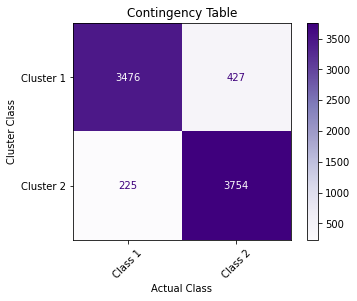

METRICS
Homogeneity Score: 0.5924052178662683
Completeness Score: 0.5939554127512687
V-Measure Score: 0.5931793025036739
Adjusted Rand Index: 0.6964515122674229
Adjusted Mutual Information: 0.5931420092491567


<Figure size 432x288 with 0 Axes>

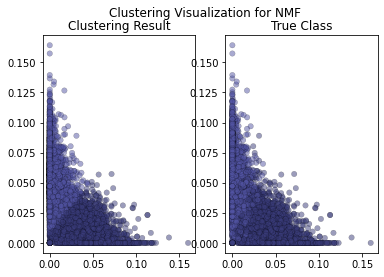

In [ ]:
nmf_train(X_train, X_labels, components=2, clusters=2)

# CLUSTERING WITH 20 CATEGORIES

In [11]:
X_20 = fetch_20newsgroups(subset='all', remove = ('headers', 'footers'), shuffle = True)
X_labels_20 = X_20.target

In [12]:
tfidf = TfidfVectorizer(min_df=3, stop_words='english')
X_train_20 = tfidf.fit_transform(X_20.data)
print(X_train_20.shape)

(18846, 45365)


In [13]:
cluster_20 = []
class_20 = []
for i in range(1, 21):
  cluster_20.append('Cluster {}'.format(i))
  class_20.append('Class {}'.format(i))

SVD

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_homogeneity_20 = list()
svd_completeness_20 = list()
svd_v_measure_20 = list()
svd_adjusted_rand_index_20 = list()
svd_adjusted_mutual_info_20 = list()


for val in r:
    print("Computing Truncated SVD for r = " + str(val) + "...")
    lsi = TruncatedSVD(n_components=val)
    output = lsi.fit_transform(X_train_20)
    scores, km = k_means(output, X_labels_20, clusters=20, plot_confusion_flag=False)
    svd_homogeneity_20.append(scores['homogeneity'])
    svd_completeness_20.append(scores['completeness'])
    svd_v_measure_20.append(scores['v_measure'])
    svd_adjusted_rand_index_20.append(scores['adjusted_rand_index'])
    svd_adjusted_mutual_info_20.append(scores['adjusted_mutual_info'])
    print("---" * 20)

Computing Truncated SVD for r = 1...
METRICS
Homogeneity Score: 0.02420471511321825
Completeness Score: 0.026694799489486692
V-Measure Score: 0.02538884787766411
Adjusted Rand Index: 0.00522251437293679
Adjusted Mutual Information: 0.022050190825309353
------------------------------------------------------------
Computing Truncated SVD for r = 2...
METRICS
Homogeneity Score: 0.21160838831334444
Completeness Score: 0.2241653450150782
V-Measure Score: 0.2177059503427928
Adjusted Rand Index: 0.06533258084458164
Adjusted Mutual Information: 0.21510134616645515
------------------------------------------------------------
Computing Truncated SVD for r = 3...
METRICS
Homogeneity Score: 0.24596753978028205
Completeness Score: 0.26426450350204655
V-Measure Score: 0.25478795631692286
Adjusted Rand Index: 0.08364433655046774
Adjusted Mutual Information: 0.25228103367196414
------------------------------------------------------------
Computing Truncated SVD for r = 5...
METRICS
Homogeneity Score: 

NMF

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]
nmf_homogeneity_20 = list()
nmf_completeness_20 = list()
nmf_v_measure_20 = list()
nmf_adjusted_rand_index_20 = list()
nmf_adjusted_mutual_info_20 = list()

for val in r:
    print("Computing NMF for r = " + str(val) + "...")
    nmf = NMF(n_components=val, init='random', random_state=42, max_iter=500)
    output = nmf.fit_transform(X_train)
    scores, km = k_means(output, X_labels, clusters=2, plot_confusion_flag=False)
    nmf_homogeneity_20.append(scores['homogeneity'])
    nmf_completeness_20.append(scores['completeness'])
    nmf_v_measure_20.append(scores['v_measure'])
    nmf_adjusted_rand_index_20.append(scores['adjusted_rand_index'])
    nmf_adjusted_mutual_info_20.append(scores['adjusted_mutual_info'])
    print("---" * 20)

Computing NMF for r = 1...
METRICS
Homogeneity Score: 0.018956544515354657
Completeness Score: 0.019260434831635448
V-Measure Score: 0.01910728144974337
Adjusted Rand Index: 0.025920756456215145
Adjusted Mutual Information: 0.01901676579673226
------------------------------------------------------------
Computing NMF for r = 2...
METRICS
Homogeneity Score: 0.49465130975968324
Completeness Score: 0.52035408497699
V-Measure Score: 0.5071772642931544
Adjusted Rand Index: 0.5291689826328091
Adjusted Mutual Information: 0.5071310027576791
------------------------------------------------------------
Computing NMF for r = 3...
METRICS
Homogeneity Score: 0.19985564752182014
Completeness Score: 0.2950307721693631
V-Measure Score: 0.23829130751886396
Adjusted Rand Index: 0.11986506221272898
Adjusted Mutual Information: 0.23820814539674384
------------------------------------------------------------
Computing NMF for r = 5...
METRICS
Homogeneity Score: 0.040791321221174695
Completeness Score: 0.1

BEST r VALUES FOR SVD AND NMF

In [ ]:
svd_mean_20 = list()
nmf_mean_20 = list()
for val in range(len(r)):
    svd_sum_20 = svd_homogeneity_20[val] + svd_completeness_20[val] + svd_v_measure_20[val] + svd_adjusted_rand_index_20[val] + svd_adjusted_mutual_info_20[val]
    nmf_sum_20 = nmf_homogeneity_20[val] + nmf_completeness_20[val] + nmf_v_measure_20[val] + nmf_adjusted_rand_index_20[val] + nmf_adjusted_mutual_info_20[val]
    svd_mean_20.append(svd_sum_20 / 5)
    nmf_mean_20.append(nmf_sum_20 / 5)

In [ ]:
best_svd_mean = max(svd_mean_20)
best_r_for_svd = r[svd_mean_20.index(best_svd_mean)]
print("The best r value for SVD is", best_r_for_svd)

The best r value for SVD is 300


However, as mentioned, there is a trade-off between the amount of information preserved and the computational cost. Looking at the graph, we see that r = 20 is a good choice of r for SVD as we preserve most of the information and reduce computational cost by a large margin.

Metrics, Contingency Table and the Clustering Results for SVD method with components = 20
CONTINGENCY TABLE:


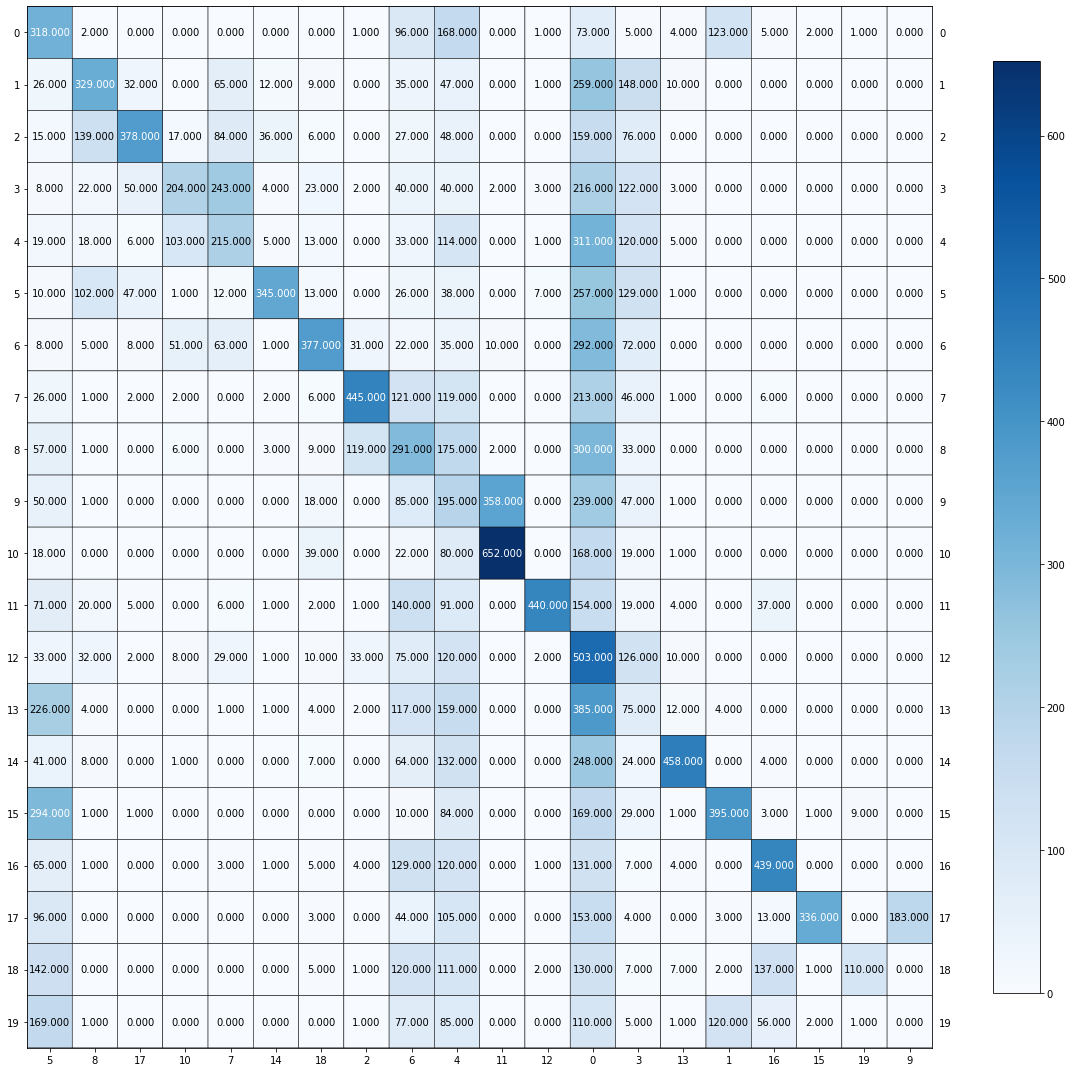

METRICS
Homogeneity Score: 0.32334046952657014
Completeness Score: 0.36636609660395814
V-Measure Score: 0.34351125974961827
Adjusted Rand Index: 0.10894336012332803
Adjusted Mutual Information: 0.3412509672839788


<Figure size 432x288 with 0 Axes>

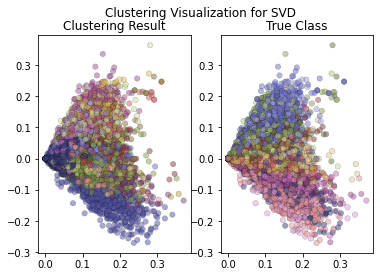

In [ ]:
svd_train(X_train_20, X_labels_20, components=20, clusters=20)

In [ ]:
best_nmf_mean = max(nmf_mean_20)
best_r_for_nmf = r[nmf_mean_20.index(best_nmf_mean)]
print("The best r value for NMF is", best_r_for_nmf)

The best r value for NMF is 2


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Metrics, Contingency Table and the Clustering Results for NMF method with components = 2
CONTINGENCY TABLE:


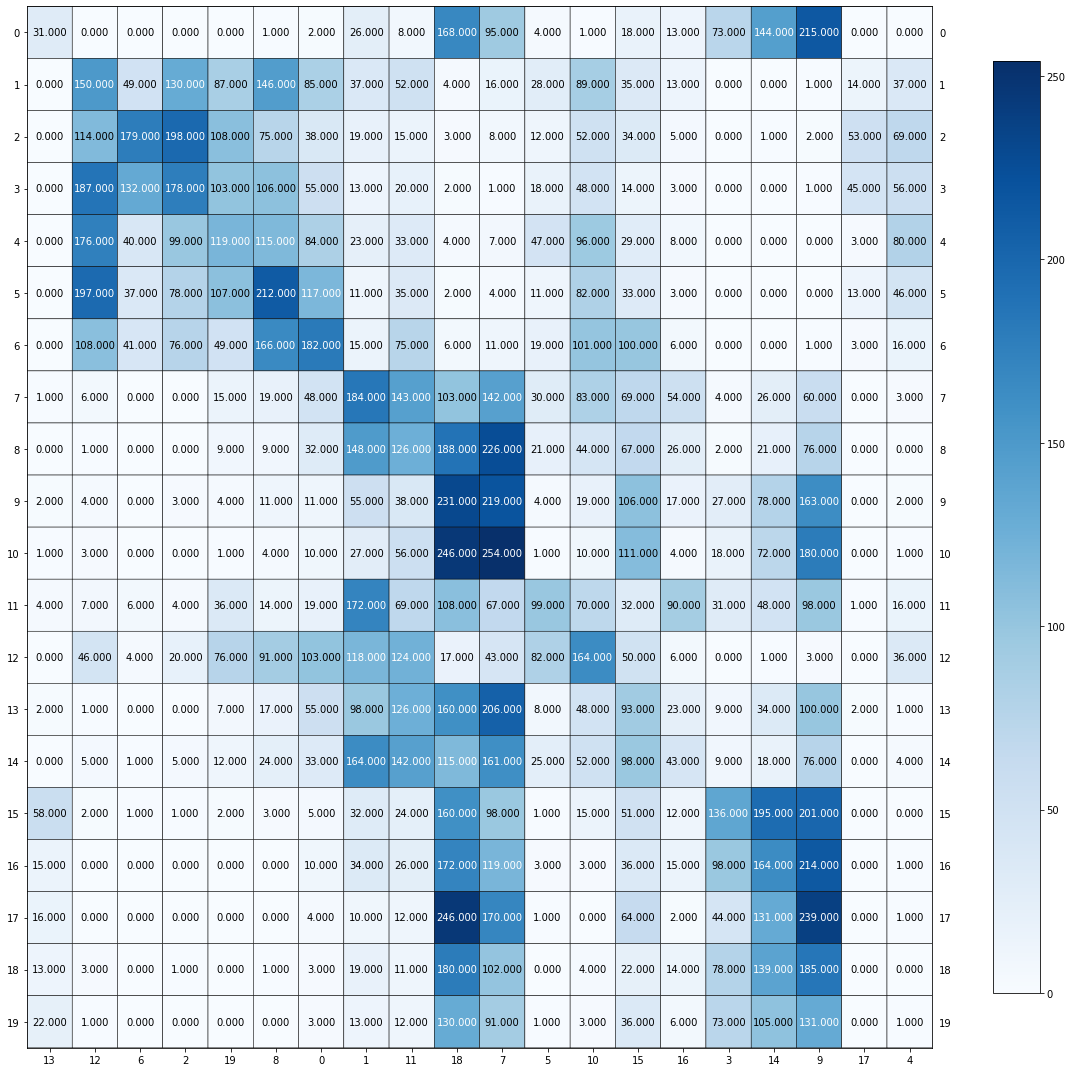

METRICS
Homogeneity Score: 0.1898184980747971
Completeness Score: 0.20221746248400904
V-Measure Score: 0.195821908574397
Adjusted Rand Index: 0.056005142509688875
Adjusted Mutual Information: 0.19313576474754998


<Figure size 432x288 with 0 Axes>

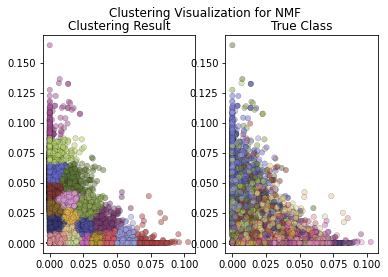

In [ ]:
nmf_train(X_train_20, X_labels_20, components=2, clusters=20)

# UMAP

In [9]:
def umap_cluster(training_data, cat_labels, clusters, metric='euclidean', components=20, method='UMAP', visualize=False, plot_contingency=False):
  reducer = umap.UMAP(n_components=components, metric=metric)
  umap_dataset = reducer.fit_transform(training_data)
  print('Metrics, Contingency Table and the Clustering Results for {} method with components = {} and metric = {}'.format(method, components, metric))
  scores, umap_km = k_means(umap_dataset, cat_labels, clusters=clusters, class_names=class_20, 
            cluster_names=cluster_20, random_state=0, max_iter=1000, n_init=500, plot_confusion_flag=plot_contingency)
  if visualize == True:
    k_means_viz(umap_km, umap_dataset, cat_labels, method)
  return scores, umap_dataset

EUCLIDEAN

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Metrics, Contingency Table and the Clustering Results for UMAP method with components = 20 and metric = euclidean
CONTINGENCY TABLE:


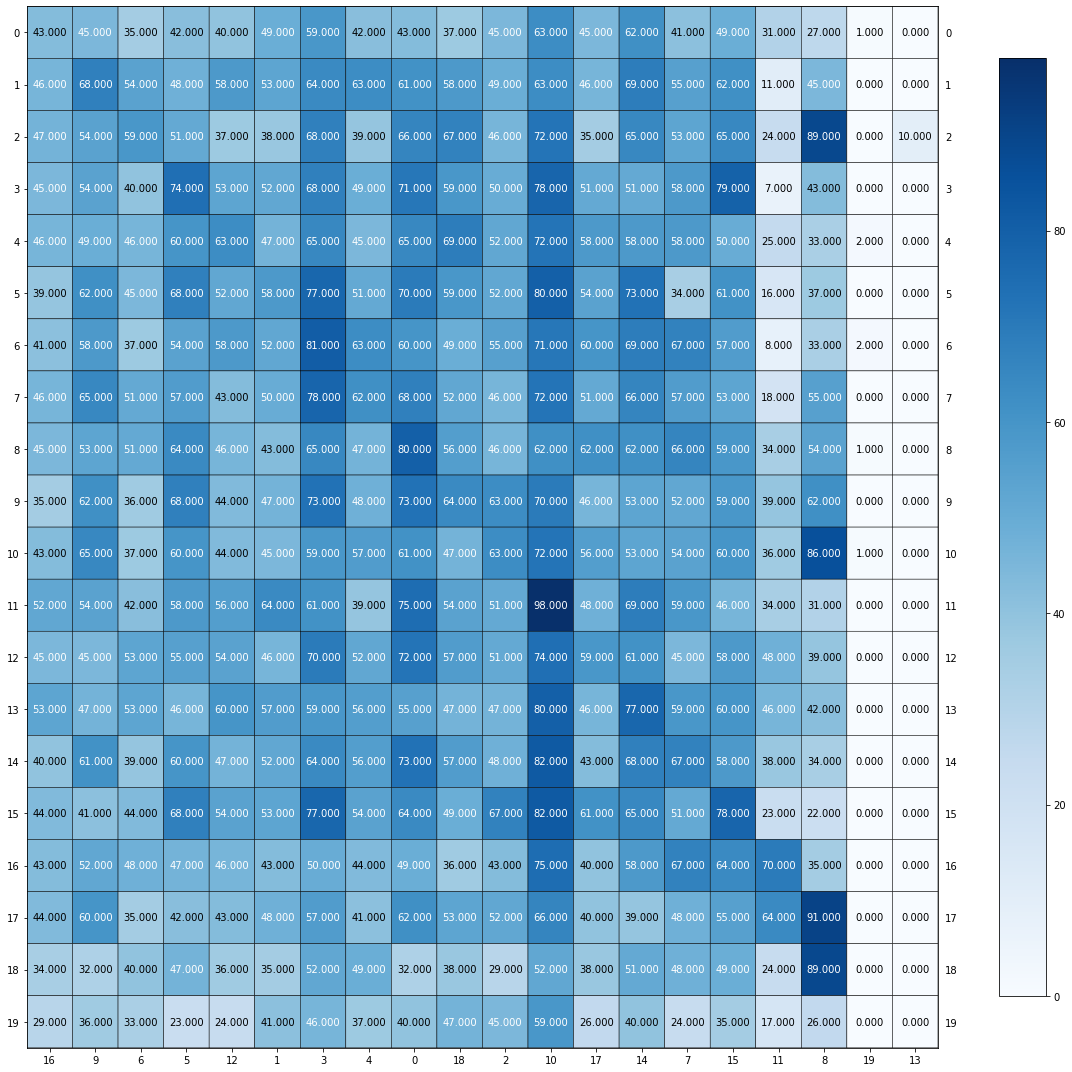

METRICS
Homogeneity Score: 0.006865294493148139
Completeness Score: 0.007126593409409929
V-Measure Score: 0.0069935040688230326
Adjusted Rand Index: 0.0009003092728012955
Adjusted Mutual Information: 0.0037411621031669716


<Figure size 432x288 with 0 Axes>

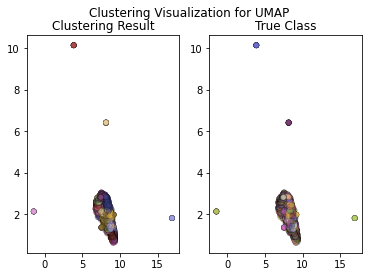

({'adjusted_mutual_info': 0.0037411621031669716,
  'adjusted_rand_index': 0.0009003092728012955,
  'completeness': 0.007126593409409929,
  'homogeneity': 0.006865294493148139,
  'v_measure': 0.0069935040688230326},
 array([[7.4602327, 2.858804 , 5.0569797, ..., 3.7426956, 5.568774 ,
         4.203876 ],
        [7.4408298, 2.9354205, 4.9884663, ..., 3.7261183, 5.528455 ,
         4.175113 ],
        [8.009443 , 1.9852569, 5.6936965, ..., 4.864662 , 5.232832 ,
         5.1623507],
        ...,
        [7.4548016, 2.8371668, 5.096728 , ..., 3.7814832, 5.5779996,
         4.303696 ],
        [8.609636 , 1.4455723, 5.927803 , ..., 5.4582615, 5.5622926,
         5.1130075],
        [7.474844 , 2.811339 , 5.126089 , ..., 3.8181565, 5.5648518,
         4.336298 ]], dtype=float32))

In [ ]:
umap_cluster(X_train_20, X_labels_20, components=20, clusters=20, visualize = True, plot_contingency = True)

COSINE

Metrics, Contingency Table and the Clustering Results for UMAP method with components = 20 and metric = cosine
CONTINGENCY TABLE:


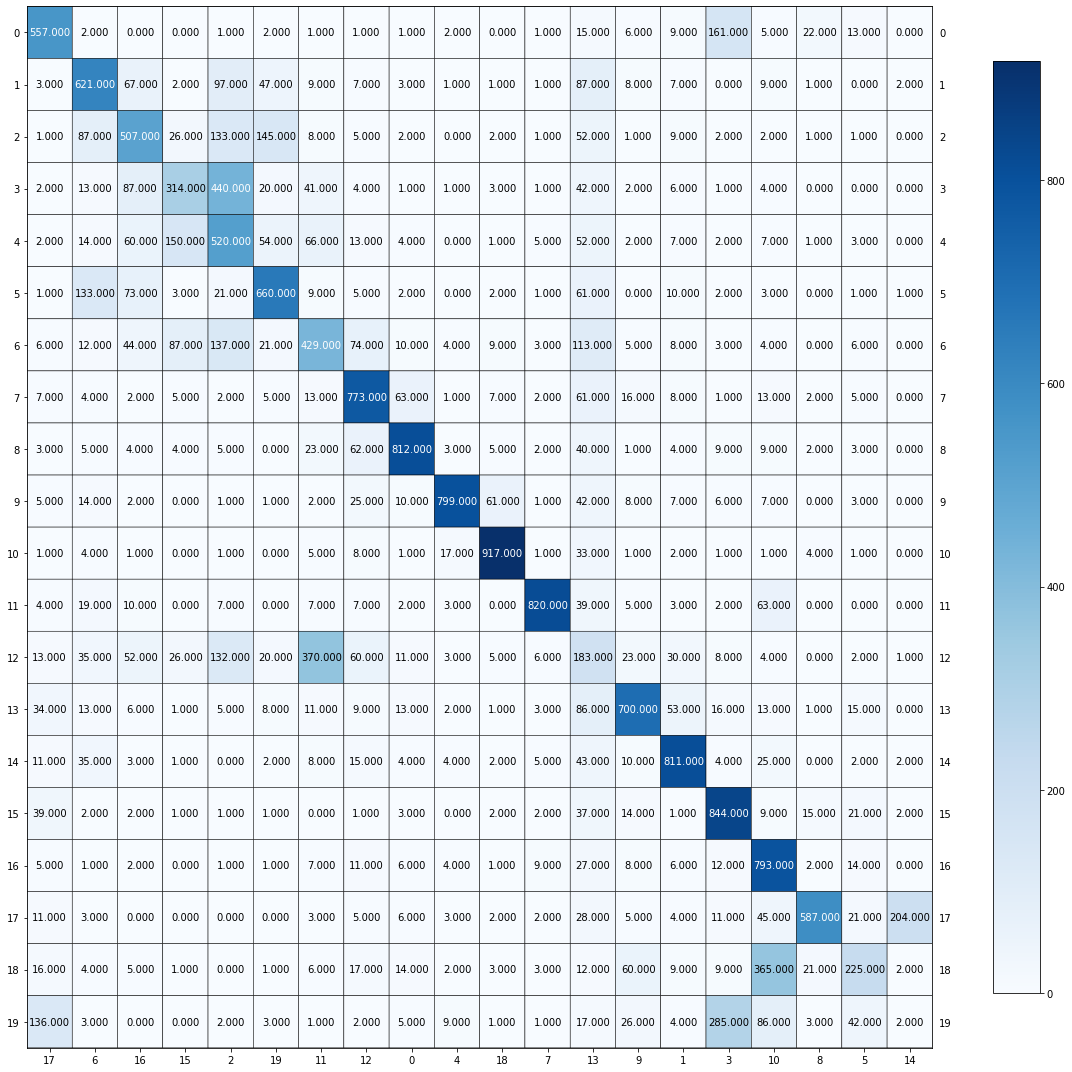

METRICS
Homogeneity Score: 0.5796460062588604
Completeness Score: 0.5904904748720413
V-Measure Score: 0.5850179889489093
Adjusted Rand Index: 0.4601539832943682
Adjusted Mutual Information: 0.5836653550925645


<Figure size 432x288 with 0 Axes>

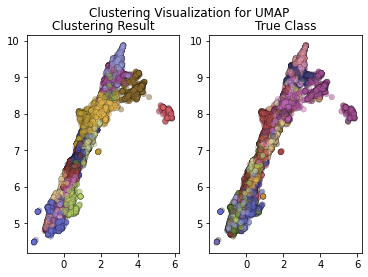

({'adjusted_mutual_info': 0.5836653550925645,
  'adjusted_rand_index': 0.4601539832943682,
  'completeness': 0.5904904748720413,
  'homogeneity': 0.5796460062588604,
  'v_measure': 0.5850179889489093},
 array([[ 0.15779573,  6.002126  ,  5.5173154 , ...,  3.6312401 ,
          4.9352884 ,  4.5065455 ],
        [-0.37996307,  4.9876833 ,  0.85408634, ...,  3.9391644 ,
          4.8870087 ,  4.9023924 ],
        [ 5.648263  ,  7.9007096 ,  2.250472  , ...,  3.3815827 ,
          4.9036303 ,  3.6768556 ],
        ...,
        [-0.6167084 ,  5.5650315 ,  1.8322897 , ...,  3.7552361 ,
          4.867232  ,  5.292525  ],
        [ 0.28500107,  5.897361  ,  1.136508  , ...,  3.4056773 ,
          5.1548276 ,  3.230088  ],
        [ 0.4937961 ,  6.439149  ,  3.0007362 , ...,  3.833908  ,
          5.043563  ,  4.0121903 ]], dtype=float32))

In [ ]:
umap_cluster(X_train_20, X_labels_20, components=20, clusters=20, metric="cosine", visualize = True, plot_contingency = True)

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50]
umap_euc_homogeneity_20 = list()
umap_euc_completeness_20 = list()
umap_euc_v_measure_20 = list()
umap_euc_adjusted_rand_index_20 = list()
umap_euc_adjusted_mutual_info_20 = list()

for val in r:
    print("Computing UMAP for metric = eclidean and r = " + str(val) + "...")
    scores, umap_euc = umap_cluster(X_train_20, X_labels_20, clusters=20, components = val, metric = "euclidean")
    umap_euc_homogeneity_20.append(scores['homogeneity'])
    umap_euc_completeness_20.append(scores['completeness'])
    umap_euc_v_measure_20.append(scores['v_measure'])
    umap_euc_adjusted_rand_index_20.append(scores['adjusted_rand_index'])
    umap_euc_adjusted_mutual_info_20.append(scores['adjusted_mutual_info'])
    print("---" * 20)

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50]
umap_cos_homogeneity_20 = list()
umap_cos_completeness_20 = list()
umap_cos_v_measure_20 = list()
umap_cos_adjusted_rand_index_20 = list()
umap_cos_adjusted_mutual_info_20 = list()

for val in r:
    print("Computing UMAP for metric = cosine and r = " + str(val) + "...")
    scores, umap_cos = umap_cluster(X_train_20, X_labels_20, clusters=20, components = val, metric = "cosine")
    umap_cos_homogeneity_20.append(scores['homogeneity'])
    umap_cos_completeness_20.append(scores['completeness'])
    umap_cos_v_measure_20.append(scores['v_measure'])
    umap_cos_adjusted_rand_index_20.append(scores['adjusted_rand_index'])
    umap_cos_adjusted_mutual_info_20.append(scores['adjusted_mutual_info'])
    print("---" * 20)

Computing UMAP for metric = cosine and r = 1...


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Metrics, Contingency Table and the Clustering Results for UMAP method with components = 1 and metric = cosine
METRICS
Homogeneity Score: 0.41732414860382705
Completeness Score: 0.4356946431268854
V-Measure Score: 0.42631158365283917
Adjusted Rand Index: 0.2794826581706759
Adjusted Mutual Information: 0.4244018576287962
------------------------------------------------------------
Computing UMAP for metric = cosine and r = 2...
Metrics, Contingency Table and the Clustering Results for UMAP method with components = 2 and metric = cosine
METRICS
Homogeneity Score: 0.5592773416652939
Completeness Score: 0.5770786704018531
V-Measure Score: 0.5680385746839691
Adjusted Rand Index: 0.441080908101485
Adjusted Mutual Information: 0.5666095278812027
------------------------------------------------------------
Computing UMAP for metric = cosine and r = 3...
Metrics, Contingency Table and the Clustering Results for UMAP method with components = 3 and metric = cosine
METRICS
Homogeneity Score: 0.5619

In [ ]:
umap_euc_mean_20 = list()
umap_cos_mean_20 = list()
for val in range(len(r)):
    umap_euc_sum_20 = umap_euc_homogeneity_20[val] + umap_euc_completeness_20[val] + umap_euc_v_measure_20[val] + umap_euc_adjusted_rand_index_20[val] + umap_euc_adjusted_mutual_info_20[val]
    umap_cos_sum_20 = umap_cos_homogeneity_20[val] + umap_cos_completeness_20[val] + umap_cos_v_measure_20[val] + umap_cos_adjusted_rand_index_20[val] + umap_cos_adjusted_mutual_info_20[val]
    umap_euc_mean_20.append(umap_euc_sum_20 / 5)
    umap_cos_mean_20.append(umap_cos_sum_20 / 5)

In [ ]:
print(r)
print("Average Scores for Euclidean UMAP for the above rs")
print(umap_euc_mean_20)
print("Average Scores for Cosine UMAP for the above rs")
print(umap_cos_mean_20)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Metrics, Contingency Table and the Clustering Results for UMAP method with components = 5 and metric = cosine
CONTINGENCY TABLE:


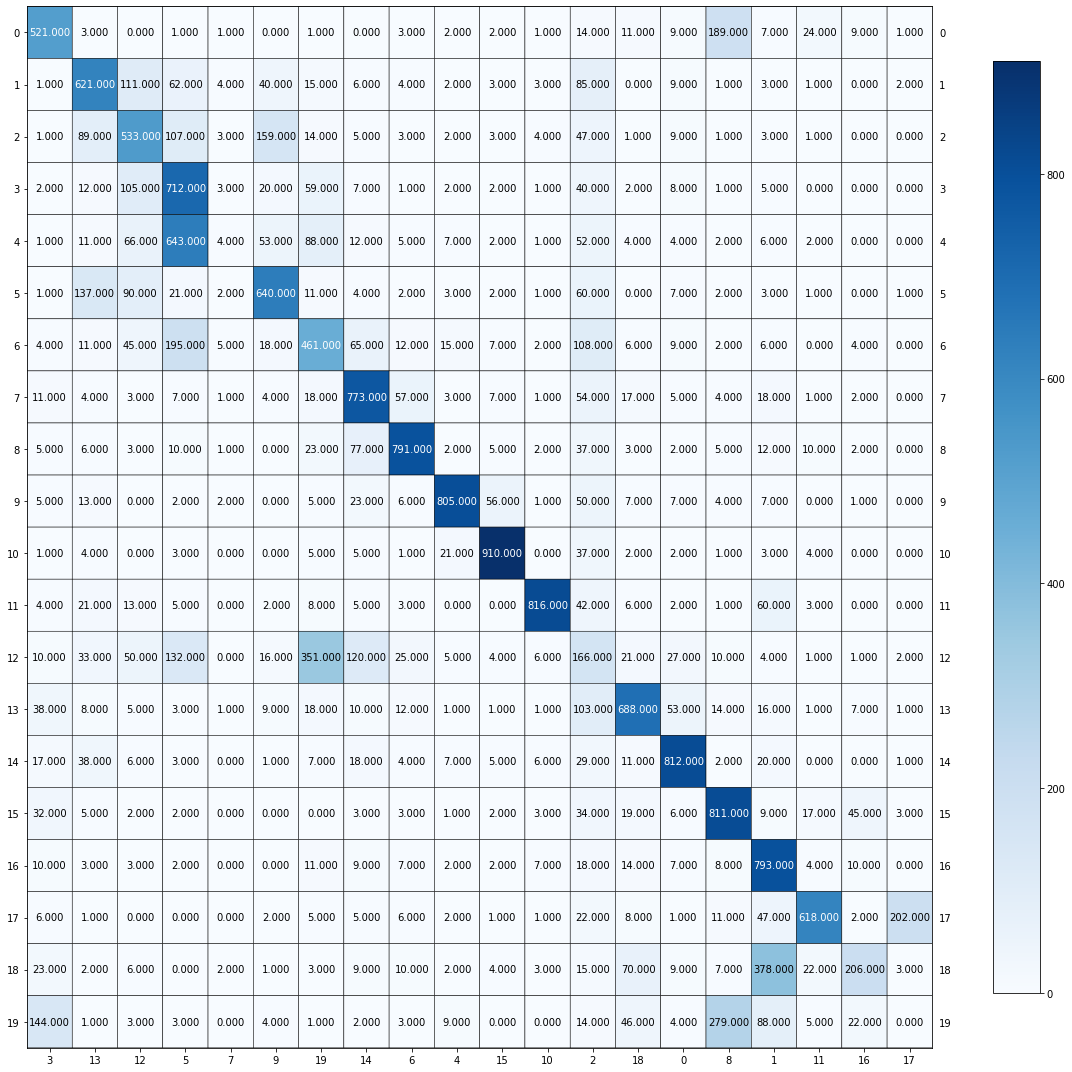

METRICS
Homogeneity Score: 0.5727279288957603
Completeness Score: 0.5948487538800385
V-Measure Score: 0.5835787915976356
Adjusted Rand Index: 0.45498647838161604
Adjusted Mutual Information: 0.5821965277765186


<Figure size 432x288 with 0 Axes>

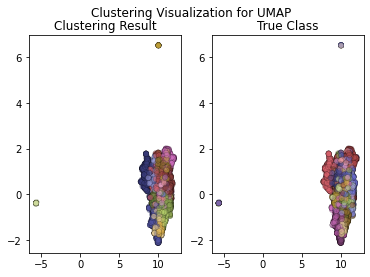

In [16]:
_, umap_euc_best = umap_cluster(X_train_20, X_labels_20, clusters=20, components = 10, metric = "euclidean", visualize = True, plot_contingency = True)
_, umap_cos_best = umap_cluster(X_train_20, X_labels_20, clusters=20, components = 5, metric = "cosine", visualize = True, plot_contingency = True)

# AGGLOMERATIVE CLUSTERING

In [ ]:
def agglomerative(training_set, labels, clusters, metric, linkage):

    agg = AgglomerativeClustering(n_clusters=clusters, linkage="ward").fit(training_set)
    print('Metrics for agglomerative clustering with linkage = {} and metric = {}'.format(linkage, metric))
    print("METRICS")    
    homogeneity = metrics.homogeneity_score(labels, agg.labels_)
    print("Homogeneity Score: {}".format(homogeneity))
    completeness = metrics.completeness_score(labels, agg.labels_)
    print("Completeness Score: {}".format(completeness))
    v_measure = metrics.v_measure_score(labels, agg.labels_)
    print("V-Measure Score: {}".format(v_measure))
    adjusted_rand_index = metrics.adjusted_rand_score(labels, agg.labels_)
    print("Adjusted Rand Index: {}".format(adjusted_rand_index))
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(labels, agg.labels_)
    print("Adjusted Mutual Information: {}".format(adjusted_mutual_info))
    
    return {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }, agg

WARD - EUCLIDEAN

In [ ]:
agg_euc_ward = agglomerative(training_set=umap_euc_best, labels=X_labels_20, clusters=20, linkage="ward", metric="euclidean")

Metrics for agglomerative clustering with linkage = ward and metric = euclidean
METRICS
Homogeneity Score: 0.007906392381999888
Completeness Score: 0.008241813464289855
V-Measure Score: 0.00807061933792446
Adjusted Rand Index: 0.000949144536167994
Adjusted Mutual Information: 0.00477623464335119


WARD-COSINE

In [ ]:
agg_cos_ward = agglomerative(training_set=umap_cos_best, labels=X_labels_20, clusters=20, linkage="ward", metric="cosine")

Metrics for agglomerative clustering with linkage = ward and metric = cosine
METRICS
Homogeneity Score: 0.5396382586619844
Completeness Score: 0.570724788310511
V-Measure Score: 0.55474636296455
Adjusted Rand Index: 0.4173923176729473
Adjusted Mutual Information: 0.5532543632479492


SINGLE-EUCLIDEAN

In [ ]:
agg_euc_single = agglomerative(training_set=umap_euc_best, labels=X_labels_20, clusters=20, linkage="single", metric="euclidean")

Metrics for agglomerative clustering with linkage = single and metric = euclidean
METRICS
Homogeneity Score: 0.006653102295820698
Completeness Score: 0.006843945430686248
V-Measure Score: 0.0067471746384873115
Adjusted Rand Index: 0.001041835634349643
Adjusted Mutual Information: 0.0034923014142200625


SINGLE-COSINE

In [ ]:
agg_cos_single = agglomerative(training_set=umap_cos_best, labels=X_labels_20, clusters=20, linkage="single", metric="cosine")

Metrics for agglomerative clustering with linkage = single and metric = cosine
METRICS
Homogeneity Score: 0.5577655297225038
Completeness Score: 0.57860451648627
V-Measure Score: 0.5679939482996659
Adjusted Rand Index: 0.42673662026527814
Adjusted Mutual Information: 0.5665617907818853


##DBSCAN

In [10]:
def dbscan(training_set, labels, eps, min_samples, plot_confusion_flag=False):
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(training_set)

    contingency_matrix = metrics.cluster.contingency_matrix(labels, model.labels_)
    
    if plot_confusion_flag == True:
        print("CONTINGENCY TABLE:")
        plot_matrix(contingency_matrix, class_names=[], cluster_names=[])
 
    homogeneity = metrics.homogeneity_score(labels, model.labels_)
    print("Homogeneity Score: {}".format(homogeneity))
    completeness = metrics.completeness_score(labels, model.labels_)
    print("Completeness Score: {}".format(completeness))
    v_measure = metrics.v_measure_score(labels, model.labels_)
    print("V-Measure Score: {}".format(v_measure))
    adjusted_rand_index = metrics.adjusted_rand_score(labels, model.labels_)
    print("Adjusted Rand Index: {}".format(adjusted_rand_index))
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(labels, model.labels_)
    print("Adjusted Mutual Information: {}".format(adjusted_mutual_info))
    
    return {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }, model

In [ ]:
best_eps = 0
best_min_samples = 0
best_score = 0
for eps in (0.5, 5):
    for min_samples in list(range(0, 100, 5)):
        print("---" * 20)
        print("Performing DBSCAN clustering for eps = {} and min_samples = {}".format(eps, min_samples))
        scores, dbscan_model = dbscan(training_set = umap_cos_best, labels=X_labels_20, eps=eps, min_samples=min_samples)
        mean_score = sum(scores.values()) / 5
        if mean_score > best_score:
            best_score = mean_score
            best_eps = eps
            best_min_samples = min_samples

------------------------------------------------------------
Performing DBSCAN clusing for eps = 0.5 and min_samples = 0
Homogeneity Score: 0.02233723661247809
Completeness Score: 0.3455285413129145
V-Measure Score: 0.041961787406255065
Adjusted Rand Index: 0.00043260833905883083
Adjusted Mutual Information: 0.0338601722289765
------------------------------------------------------------
Performing DBSCAN clusing for eps = 0.5 and min_samples = 5
Homogeneity Score: 0.02302158999159594
Completeness Score: 0.3257914649692914
V-Measure Score: 0.04300433956020038
Adjusted Rand Index: 0.0004520796924656256
Adjusted Mutual Information: 0.036042546750279986
------------------------------------------------------------
Performing DBSCAN clusing for eps = 0.5 and min_samples = 10
Homogeneity Score: 0.022516172167124156
Completeness Score: 0.29035613078238354
V-Measure Score: 0.04179154606428196
Adjusted Rand Index: 0.0004657622010655394
Adjusted Mutual Information: 0.035853644656272055
----------

 DBSCAN performed best with eps = 0.5 and min_samples = 90
CONTINGENCY TABLE:


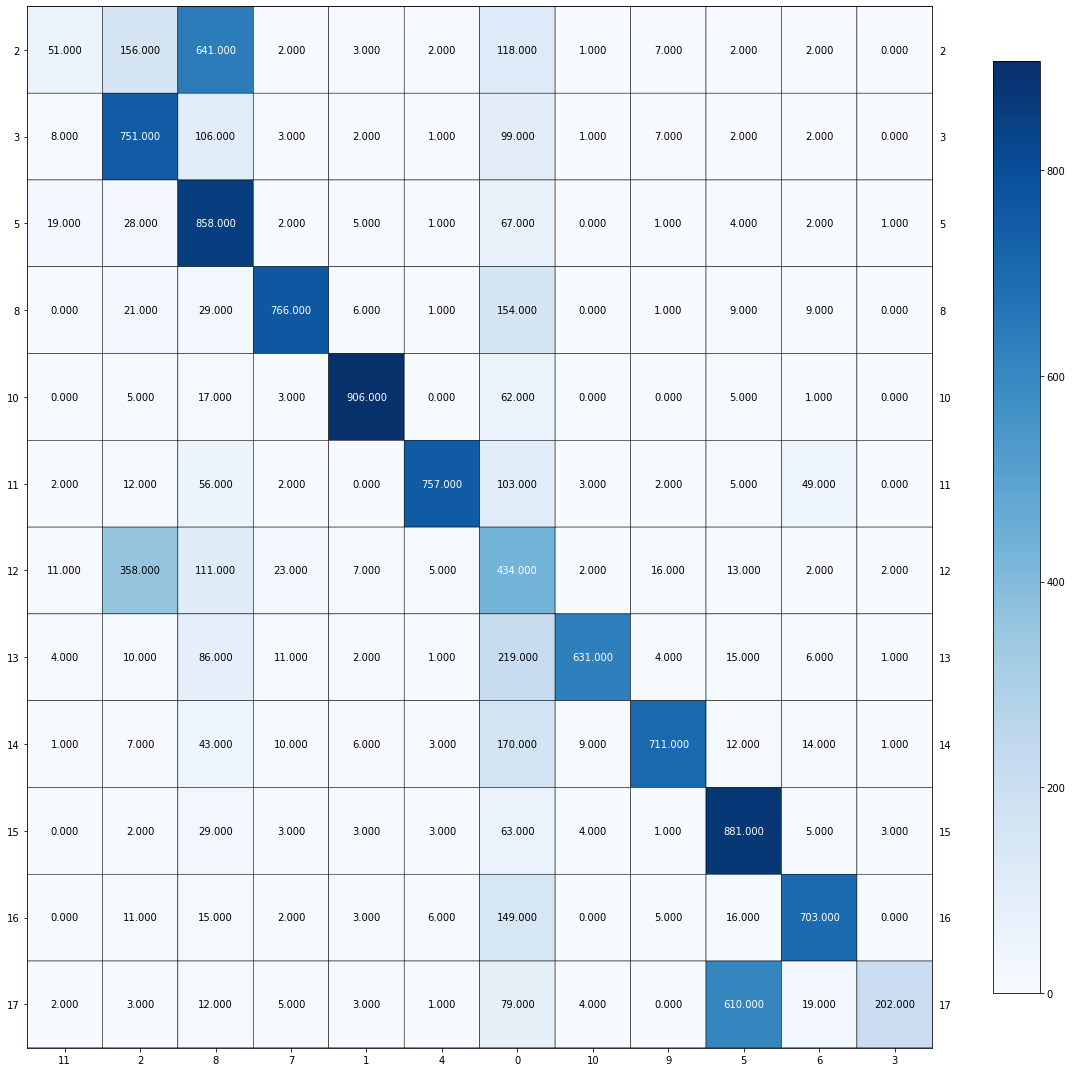

Homogeneity Score: 0.44577653767907954
Completeness Score: 0.5955570694801253
V-Measure Score: 0.5098949397156264
Adjusted Rand Index: 0.2850332596155018
Adjusted Mutual Information: 0.5088466339142773
11


In [18]:
print(" DBSCAN performed best with eps = {} and min_samples = {}".format(0.5, 90))
scores, best_dbscan_model = dbscan(training_set = umap_cos_best, labels=X_labels_20, eps=0.5, min_samples=90, plot_confusion_flag=True)
dbscan_labels = best_dbscan_model.labels_
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(n_clusters_)

# HDBSCAN

In [20]:
def hdbscan_fn(training_set, labels, min_cluster_size, cluster_selection_epsilon, min_samples, plot_confusion_flag=False):
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon, min_samples=min_samples).fit(training_set)
    print('Metrics for HDBSCAN clustering with cluster_selection_epsilon = {} and min_samples = {}'.format(cluster_selection_epsilon, min_samples))

    contingency_matrix = metrics.cluster.contingency_matrix(labels, model.labels_)
    
    if plot_confusion_flag == True:
        print("CONTINGENCY TABLE:")
        plot_matrix(contingency_matrix, class_names=[], cluster_names=[])

    homogeneity = metrics.homogeneity_score(labels, model.labels_)
    print("Homogeneity Score: {}".format(homogeneity))
    completeness = metrics.completeness_score(labels, model.labels_)
    print("Completeness Score: {}".format(completeness))
    v_measure = metrics.v_measure_score(labels, model.labels_)
    print("V-Measure Score: {}".format(v_measure))
    adjusted_rand_index = metrics.adjusted_rand_score(labels, model.labels_)
    print("Adjusted Rand Index: {}".format(adjusted_rand_index))
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(labels, model.labels_)
    print("Adjusted Mutual Information: {}".format(adjusted_mutual_info))
    
    return {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }, model

In [ ]:
best_cluster_selection_epsilon  = 0
best_min_samples = 0
best_score = 0
for cluster_selection_epsilon in (0.5, 5):
    for min_samples in list(range(5, 100, 5)):
        print("---" * 20)
        scores, hdbscan_model = hdbscan_fn(training_set = umap_cos_best, labels=X_labels_20, min_cluster_size=100, cluster_selection_epsilon=cluster_selection_epsilon, min_samples=min_samples)
        mean_score = sum(scores.values()) / 5
        if mean_score > best_score:
            best_score = mean_score
            best_cluster_selection_epsilon = cluster_selection_epsilon
            best_min_samples = min_samples

------------------------------------------------------------
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.011616039438522744
Completeness Score: 0.4401647780047533
V-Measure Score: 0.02263474332392959
Adjusted Rand Index: 0.000502631059333763
Adjusted Mutual Information: 0.021943387297662795
------------------------------------------------------------
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10
Homogeneity Score: 0.011616731785048866
Completeness Score: 0.424943034614663
V-Measure Score: 0.02261522768235811
Adjusted Rand Index: 0.0004978672890139047
Adjusted Mutual Information: 0.02193154729124353
------------------------------------------------------------
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 15
Homogeneity Score: 0.09358705710998141
Completeness Score: 0.4597073702094078
V-Measure Score: 0.15551452458360795
Adjusted Rand Index: 

Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 35
CONTINGENCY TABLE:


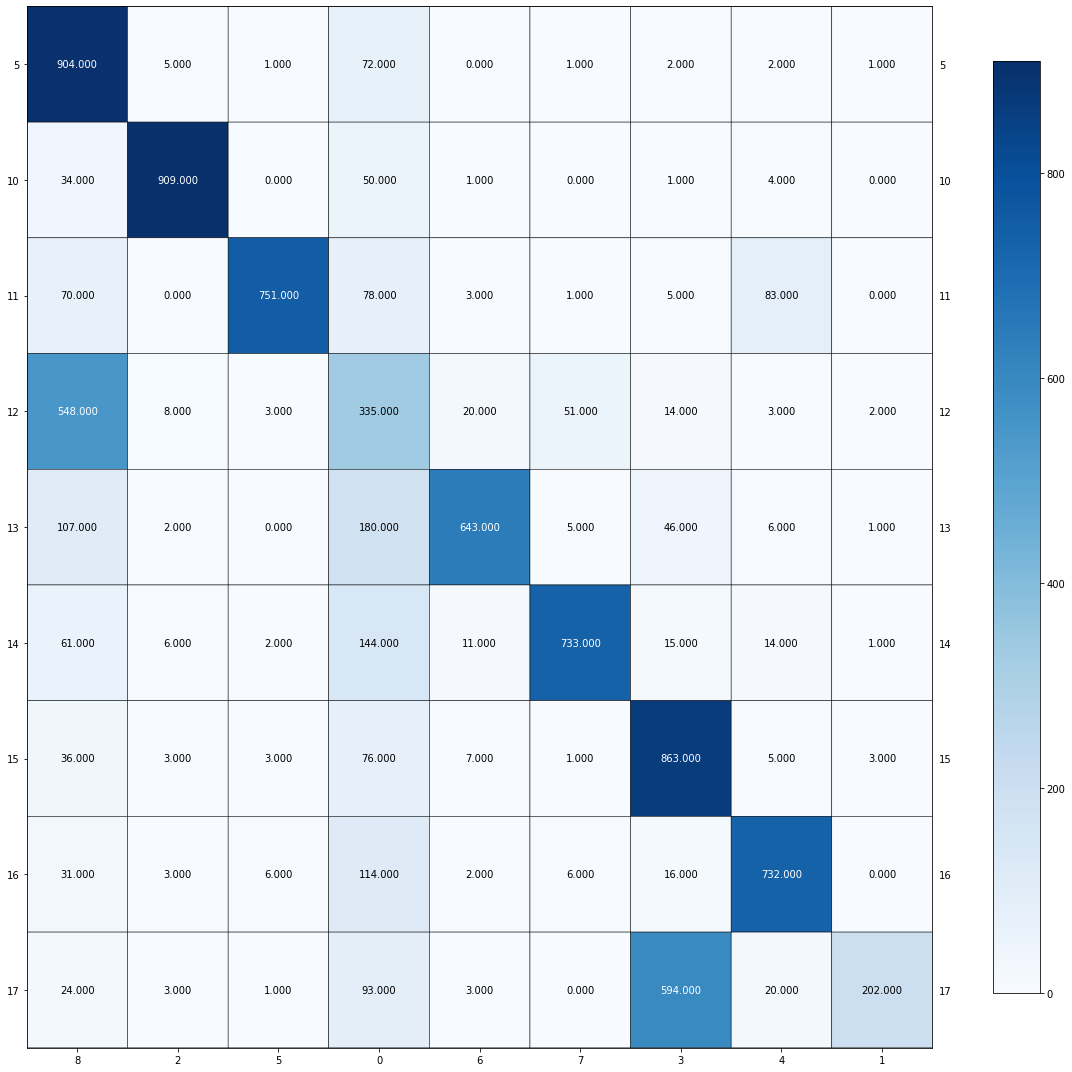

Homogeneity Score: 0.35956430060476746
Completeness Score: 0.6001997338208879
V-Measure Score: 0.4497155337637152
Adjusted Rand Index: 0.17005563487114303
Adjusted Mutual Information: 0.44878119338066924
8


In [21]:
scores, best_hdbscan_model = hdbscan_fn(training_set = umap_cos_best, labels=X_labels_20, min_cluster_size=100, cluster_selection_epsilon=0.5, min_samples=35, plot_confusion_flag=True)
hdbscan_labels = best_hdbscan_model.labels_
n_clusters_ = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print(n_clusters_)

# GRID SEARCH FOR BEST DIMENSIONALITY REDUCTION AND CLUSTERING PIPELINE

SVD

In [ ]:
best_r  = 0
best_k = 0
best_score = 0
best_min_cluster_size = 0
best_clusterer = ""
best_linkage = ""
best_eps = 0
best_min_samples = 0
best_cluster_selection_epsilon = 0

for r_val in [5, 20, 200]:
    print("---" * 20)
    print("___" * 20)
    print("---" * 20)
    print("Computing Truncated SVD for r = " + str(r_val) + "...")
    lsi = TruncatedSVD(n_components=r_val)
    svd_output = lsi.fit_transform(X_train_20)
                
    for min_cluster_size in (100, 200):
        for cluster_selection_epsilon in ([0.5]):
            for min_samples in list(range(5, 100, 5)):
                print("---" * 20)
                print("Computing HDBSCAN Clustering for min_cluster_size = {}, eps = {}, and min_samples = {}".format(min_cluster_size, cluster_selection_epsilon, min_samples))
                hdb_scores, hdbscan_model = hdbscan_fn(training_set = svd_output, labels=X_labels_20, min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon, min_samples=min_samples)
                hdb_score = hdb_scores["adjusted_rand_index"]
                if hdb_score > best_score:
                    best_clusterer = "hdbscan"
                    best_score = hdb_score
                    best_cluster_selection_epsilon = cluster_selection_epsilon
                    best_min_samples = min_samples
                    best_min_cluster_size = min_cluster_size
                    best_r = r_val
    for eps in (0.5, 5):
        for min_samples in list(range(0, 100, 5)):
            print("---" * 20)
            print("Computing DBSCAN Clustering for eps = {}, and min_samples = {}".format(eps, min_samples))
            db_scores, dbscan_model = dbscan(training_set = svd_output, labels=X_labels_20, eps=eps, min_samples=min_samples)
            db_score = db_scores["adjusted_rand_index"]
            if db_score > best_score:
                best_clusterer = "dbscan"
                best_score = db_score
                best_eps = eps
                best_min_samples = min_samples
                best_r = r_val
    for k_val in [10, 20, 50]:
        print("---" * 20)
        print("Computing k-Means for k = {}".format(k_val))
        km_scores, km = k_means(svd_output, X_labels_20, clusters=k_val, plot_confusion_flag=False)
        km_score = km_scores["adjusted_rand_index"]
        if km_score > best_score:
            best_clusterer = "k-means"
            best_score = km_score
            best_k = k_val
            best_r = r_val
    for linkage in ("ward", "single"):
        print("---" * 20)
        print("Computing Agglomerative Clustering for n_clusters = 20, metric = cosine and linkage = {}".format(linkage))
        agg_scores, agg = agglomerative(training_set=svd_output, labels=X_labels_20, clusters=20, linkage=linkage, metric="cosine")        
        agg_score = agg_scores["adjusted_rand_index"]
        if agg_score > best_score:
            best_clusterer = "agglomerative"
            best_score = agg_score
            best_linkage = linkage
            best_r = r_val

------------------------------------------------------------
____________________________________________________________
------------------------------------------------------------
Computing Truncated SVD for r = 5...
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 5
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.0
Completeness Score: 1.0
V-Measure Score: 0.0
Adjusted Rand Index: 0.0
Adjusted Mutual Information: -1.6056889920887454e-16
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 10
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10
Homogeneity Score: 0.0
Completeness Score: 1.0
V-Measure Score: 0.0
Adjusted Rand Index: 0.0
Adjusted Mutual Information: -1.6056889920887454e-16
------------

In [ ]:
print(best_clusterer)
print(best_r)
print(best_k)
print(best_score)
print(best_min_cluster_size)
print(best_linkage)
print(best_eps)
print(best_min_samples)
print(best_cluster_selection_epsilon)

agglomerative
20
50
0.16773108164444625
0
ward
0
0
0


NMF

In [ ]:
best_r  = 0
best_k = 0
best_score = 0
best_min_cluster_size = 0
best_clusterer = ""
best_linkage = ""
best_eps = 0
best_min_samples = 0
best_cluster_selection_epsilon = 0

for r_val in [5, 20, 200]:
    print("---" * 20)
    print("___" * 20)
    print("---" * 20)
    print("Computing NMF for r = " + str(r_val) + "...")
    nmf = NMF(n_components=r_val)
    nmf_output = nmf.fit_transform(X_train_20)
                
    for min_cluster_size in (100, 200):
        for min_samples in list(range(5, 100, 5)):
            print("---" * 20)
            print("Computing HDBSCAN Clustering for min_cluster_size = {}, eps = {}, and min_samples = {}".format(min_cluster_size, 0.5, min_samples))
            hdb_scores, hdbscan_model = hdbscan_fn(training_set = nmf_output, labels=X_labels_20, min_cluster_size=min_cluster_size, cluster_selection_epsilon=0.5, min_samples=min_samples)
            hdb_score = hdb_scores["adjusted_rand_index"]
            if hdb_score > best_score:
                best_clusterer = "hdbscan"
                best_score = hdb_score
                best_cluster_selection_epsilon = 0.5
                best_min_samples = min_samples
                best_min_cluster_size = min_cluster_size
                best_r = r_val
    for min_samples in list(range(5, 100, 5)):
        print("---" * 20)
        print("Computing DBSCAN Clustering for eps = {}, and min_samples = {}".format(0.5, min_samples))
        db_scores, dbscan_model = dbscan(training_set = nmf_output, labels=X_labels_20, eps=0.5, min_samples=min_samples)
        db_score = db_scores["adjusted_rand_index"]
        if db_score > best_score:
            best_clusterer = "dbscan"
            best_score = db_score
            best_eps = 0.5
            best_min_samples = min_samples
            best_r = r_val
    for k_val in [10, 20, 50]:
        print("---" * 20)
        print("Computing k-Means for k = {}".format(k_val))
        km_scores, km = k_means(nmf_output, X_labels_20, clusters=k_val, plot_confusion_flag=False)
        km_score = km_scores["adjusted_rand_index"]
        if km_score > best_score:
            best_clusterer = "k-means"
            best_score = km_score
            best_k = k_val
            best_r = r_val
    for linkage in ("ward", "single"):
        print("---" * 20)
        print("Computing Agglomerative Clustering for n_clusters = 20, metric = cosine and linkage = {}".format(linkage))
        agg_scores, agg = agglomerative(training_set=nmf_output, labels=X_labels_20, clusters=20, linkage=linkage, metric="cosine")        
        agg_score = agg_scores["adjusted_rand_index"]
        if agg_score > best_score:
            best_clusterer = "agglomerative"
            best_score = agg_score
            best_linkage = linkage
            best_r = r_val

------------------------------------------------------------
____________________________________________________________
------------------------------------------------------------
Computing NMF for r = 5...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 5
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.02408272299714592
Completeness Score: 0.16181914007394946
V-Measure Score: 0.0419258361552505
Adjusted Rand Index: 0.004256337427125559
Adjusted Mutual Information: 0.04135516050406972
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 10
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10
Homogeneity Score: 0.02694759321217841
Completeness Score: 0.16135371580128882
V-Measure Score: 0.04618230557680936
Adjusted Rand Index: 0.006503067524348004
Adjusted Mutual Information: 0.04561926478424191
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 5
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.018856657158595268
Completeness Score: 0.14076738722531346
V-Measure Score: 0.03325817699036502
Adjusted Rand Index: 0.0030380458046400088
Adjusted Mutual Information: 0.03267652388902656
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 10
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10
Homogeneity Score: 0.016284736097745688
Completeness Score: 0.1351805072362487
V-Measure Score: 0.02906777604479827
Adjusted Rand Index: 0.002332427265561711
Adjusted Mutual Information: 0.028474219537253886
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_s

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 5
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.022451053903022298
Completeness Score: 0.09285197891414584
V-Measure Score: 0.036159062475126603
Adjusted Rand Index: 0.011281054127873998
Adjusted Mutual Information: 0.0356227173055336
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 10
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10
Homogeneity Score: 0.0
Completeness Score: 1.0
V-Measure Score: 0.0
Adjusted Rand Index: 0.0
Adjusted Mutual Information: -1.6056889920887454e-16
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 15
Metrics for HDBSCAN 

In [ ]:
print(best_clusterer)
print(best_r)
print(best_k)
print(best_score)
print(best_min_cluster_size)
print(best_linkage)
print(best_eps)
print(best_min_samples)
print(best_cluster_selection_epsilon)

agglomerative
20
50
0.1296894382492644
100
ward
0
95
0.5


UMAP

In [ ]:
best_r  = 0
best_k = 0
best_score = 0
best_min_cluster_size = 0
best_clusterer = ""
best_linkage = ""
best_eps = 0
best_min_samples = 0
best_cluster_selection_epsilon = 0

for r_val in [5, 20, 200]:
    print("---" * 20)
    print("___" * 20)
    print("---" * 20)
    print("Computing UMAP for metric = cosine and n_components = " + str(r_val) + "...")
    _, umap_output = umap_cluster(X_train_20, X_labels_20, clusters=20, components = r_val, metric = "cosine")
                
    for min_cluster_size in (100, 200):
        for min_samples in list(range(5, 100, 5)):
            print("---" * 20)
            print("Computing HDBSCAN Clustering for min_cluster_size = {}, eps = {}, and min_samples = {}".format(min_cluster_size, 0.5, min_samples))
            hdb_scores, hdbscan_model = hdbscan_fn(training_set = umap_output, labels=X_labels_20, min_cluster_size=min_cluster_size, cluster_selection_epsilon=0.5, min_samples=min_samples)
            hdb_score = hdb_scores["adjusted_rand_index"]
            if hdb_score > best_score:
                best_clusterer = "hdbscan"
                best_score = hdb_score
                best_cluster_selection_epsilon = 0.5
                best_min_samples = min_samples
                best_min_cluster_size = min_cluster_size
                best_r = r_val
    for min_samples in list(range(5, 100, 5)):
        print("---" * 20)
        print("Computing DBSCAN Clustering for eps = {}, and min_samples = {}".format(0.5, min_samples))
        db_scores, dbscan_model = dbscan(training_set = umap_output, labels=X_labels_20, eps=0.5, min_samples=min_samples)
        db_score = db_scores["adjusted_rand_index"]
        if db_score > best_score:
            best_clusterer = "dbscan"
            best_score = db_score
            best_eps = 0.5
            best_min_samples = min_samples
            best_r = r_val
    for k_val in [10, 20, 50]:
        print("---" * 20)
        print("Computing k-Means for k = {}".format(k_val))
        km_scores, km = k_means(umap_output, X_labels_20, clusters=k_val, plot_confusion_flag=False)
        km_score = km_scores["adjusted_rand_index"]
        if km_score > best_score:
            best_clusterer = "k-means"
            best_score = km_score
            best_k = k_val
            best_r = r_val
    for linkage in ("ward", "single"):
        print("---" * 20)
        print("Computing Agglomerative Clustering for n_clusters = 20, metric = cosine and linkage = {}".format(linkage))
        agg_scores, agg = agglomerative(training_set=umap_output, labels=X_labels_20, clusters=20, linkage=linkage, metric="cosine")        
        agg_score = agg_scores["adjusted_rand_index"]
        if agg_score > best_score:
            best_clusterer = "agglomerative"
            best_score = agg_score
            best_linkage = linkage
            best_r = r_val

------------------------------------------------------------
____________________________________________________________
------------------------------------------------------------
Computing UMAP for metric = cosine and n_components = 5...


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Metrics, Contingency Table and the Clustering Results for UMAP method with components = 5 and metric = cosine
METRICS
Homogeneity Score: 0.5659087130761308
Completeness Score: 0.5993549147442029
V-Measure Score: 0.5821518159168741
Adjusted Rand Index: 0.44690190771025645
Adjusted Mutual Information: 0.5807506014272837
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 5
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 5
Homogeneity Score: 0.09813715835868016
Completeness Score: 0.6851639879280977
V-Measure Score: 0.17168376965542442
Adjusted Rand Index: 0.01976780637165248
Adjusted Mutual Information: 0.17093876767175337
------------------------------------------------------------
Computing HDBSCAN Clustering for min_cluster_size = 100, eps = 0.5, and min_samples = 10
Metrics for HDBSCAN clustering with cluster_selection_epsilon = 0.5 and min_samples = 10

In [ ]:
print(best_clusterer)
print(best_r)
print(best_k)
print(best_score)
print(best_min_cluster_size)
print(best_linkage)
print(best_eps)
print(best_min_samples)
print(best_cluster_selection_epsilon)

k-means
200
20
0.44807269776043457
100

0.5
90
0.5


NO DIMENSIONALITY REDUCTION

In [ ]:
best_r  = 0
best_k = 0
best_score = 0
best_min_cluster_size = 0
best_clusterer = ""
best_linkage = ""
best_eps = 0
best_min_samples = 0
best_cluster_selection_epsilon = 0

            
for min_cluster_size in (100, 200):
    for min_samples in list(range(5, 100, 5)):
        print("---" * 20)
        print("Computing HDBSCAN Clustering for min_cluster_size = {}, eps = {}, and min_samples = {}".format(min_cluster_size, 0.5, min_samples))
        hdb_scores, hdbscan_model = hdbscan_fn(training_set = X_train_20, labels=X_labels_20, min_cluster_size=min_cluster_size, cluster_selection_epsilon=0.5, min_samples=min_samples)
        hdb_mean_score = sum(hdb_scores.values()) / 5
        if hdb_mean_score > best_score:
            best_clusterer = "hdbscan"
            best_score = hdb_mean_score
            best_cluster_selection_epsilon = 0.5
            best_min_samples = min_samples
            best_min_cluster_size = min_cluster_size
            best_r = r_val
for min_samples in list(range(5, 100, 5)):
    print("---" * 20)
    print("Computing DBSCAN Clustering for eps = {}, and min_samples = {}".format(0.5, min_samples))
    db_scores, dbscan_model = dbscan(training_set = X_train_20, labels=X_labels_20, eps=0.5, min_samples=min_samples)
    db_mean_score = sum(db_scores.values()) / 5
    if db_mean_score > best_score:
        best_clusterer = "dbscan"
        best_score = db_mean_score
        best_eps = 0.5
        best_min_samples = min_samples
        best_r = r_val
for k_val in [10, 20, 50]:
    print("---" * 20)
    print("Computing k-Means for k = {}".format(k_val))
    km_scores, km = k_means(X_train_20, X_labels_20, clusters=k_val, plot_confusion_flag=False)
    km_mean_score = sum(km_scores.values()) / 5
    if km_mean_score > best_score:
        best_clusterer = "k-means"
        best_score = km_mean_score
        best_k = k_val
        best_r = r_val
for linkage in ("ward", "single"):
    print("---" * 20)
    print("Computing Agglomerative Clustering for n_clusters = 20, metric = cosine and linkage = {}".format(linkage))
    agg_scores, agg = agglomerative(training_set=X_train_20, labels=X_labels_20, clusters=20, linkage=linkage, metric="cosine")        
    agg_mean_score = sum(agg_scores.values()) / 5
    if agg_mean_score > best_score:
        best_clusterer = "agglomerative"
        best_score = agg_mean_score
        best_linkage = linkage
        best_r = r_val

NO DIMENSIONALITY REDUCTION CANNOT BE RUN! NOT ENOUGH MEMORY

In [ ]:
print(best_clusterer)
print(best_r)
print(best_k)
print(best_score)
print(best_min_cluster_size)
print(best_linkage)
print(best_eps)
print(best_min_samples)
print(best_cluster_selection_epsilon)